In [30]:
# import libraries
import pandas as pd
import numpy as np
import time
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
pd.plotting.register_matplotlib_converters()

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
# from sklearn.cross_validation import KFold, cross_val_score

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_curve

from sklearn import datasets, linear_model, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier


import scikitplot as skplt
import matplotlib.pyplot as plt

## I. DATA Processing

https://www.kaggle.com/henriqueyamahata/bank-marketing

In [7]:
def remove_duplicated_row(df):
    df = df.drop(df[df.duplicated()].index).reset_index(drop=True)
    return(df)

def remove_features(df,col_lst):
    for col in col_lst:
        df.pop(col)
    return(df)

def replace_missing_by_value(df,column,replaced_value,missing_value='unknown'):
    df[column] = df[column].apply(lambda val: replaced_value if val == missing_value else val)
    return df

def replace_outlier_by_quantile(df, column, quantile_thresh = 0.95, replaced_value = None):
    thresh_value = df[column].quantile(quantile_thresh)
    if (replaced_value == None):
        replaced_value = thresh_value
        
    df[column] = df[column].apply(lambda val: replaced_value if val > thresh_value  else val)
    return df

def replace_outlier_by_value(df, column, value_thresh, replaced_value = None):
    if (replaced_value == None):
        replaced_value = value_thresh
        
    df[column] = df[column].apply(lambda val: replaced_value if val > value_thresh else val)
    return df

def replace_missing_by_mode(df,column,missing_value='unknown'):
    replaced_value = df[column].mode().values.tolist()[0]
    df[column] = df[column].apply(lambda val: replaced_value if val == missing_value else val)
    
    return df

def replace_missing_by_median(df,column,missing_value='unknown'):
    replaced_value = df[column].median().values.tolist()[0]
    df[column] = df[column].apply(lambda val: replaced_value if val == missing_value else val)
    return df

def transform_pdays(val):
    transform_dict = {999:'not_previously_contacted',7: 'over_a_week',0:'within_a_week'}
    for key in transform_dict.keys():
        if (val >= key):
            return transform_dict[key]

def eval_class(true, predicted):
    acc = metrics.accuracy_score(true, predicted)
    precision = metrics.precision_score(true, predicted)
    recall = metrics.recall_score(true, predicted)
    f1 = metrics.f1_score(true, predicted)
    log_loss = metrics.log_loss(true, predicted)
    auc = metrics.roc_auc_score(true, predicted)
    return acc, precision, recall, f1, log_loss, auc

def create_evaluation_df(model_name, y_train,y_train_pred, y_test, y_test_pred):
    eval_clm_metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'Log_loss','AUC']
    eval_clm_train = [m + '_train' for m in eval_clm_metrics]
    eval_clm_test = [m + '_test' for m in eval_clm_metrics]
    dis_clm = ['Model','Accuracy_train'] + eval_clm_test + ['diff_Acc_train_test']
    dis_clm_1 = ['Model','Accuracy_train','Accuracy_test','Precision_test','Recall_test','F1_test']
  
    res_clm = pd.DataFrame(data=[[model_name,*eval_class(y_train,y_train_pred),
                                 *eval_class(y_test, y_test_pred)]],
                          columns=['Model'] + eval_clm_train + eval_clm_test)
    res_clm['diff_Acc_train_test'] = res_clm.apply(lambda x: (x.Accuracy_test - x.Accuracy_train)/x.Accuracy_train, axis=1)
    
    return(res_clm[dis_clm_1])

def init_evaluation_df():
    eval_clm_metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'Log_loss','AUC']
    eval_clm_train = [m + '_train' for m in eval_clm_metrics]
    eval_clm_test = [m + '_test' for m in eval_clm_metrics]
    dis_clm = ['Model','Accuracy_train'] + eval_clm_test + ['diff_Acc_train_test']
    dis_clm_1 = ['Model','Accuracy_train','Accuracy_test','Precision_test','Recall_test','F1_test']
    
    res_clm = pd.DataFrame( columns=['Model'] + eval_clm_train + eval_clm_test + ['diff_Acc_train_test'])

    return(res_clm[dis_clm_1])
        
def data_processing_pipeline(df):
    # remove duplicated rows
    df = remove_duplicated_row(df)
    
    # remove duration and nr.employed
#     remove_cols =['duration', 'nr.employed'] 
#     df = remove_features(df,remove_cols)
    
    # edu_unknown = 'unknown'
    column = 'education'
    replaced_value = df[column].mode().values.tolist()[0]
    df = replace_missing_by_value(df,column,replaced_value)

    # housing_unknown = 'unknown'
    column = 'housing'
    replaced_value  = 'yes' #df[column].mode().values.tolist()[0]
    df = replace_missing_by_value(df,column,replaced_value)

    # loan_unknown = 'unknown'
    column = 'loan'
    replaced_value  = 'no' # df[column].mode().values.tolist()[0]
    df = replace_missing_by_value(df,column,replaced_value)

    # marital_unknown = 'unknown'
    column = 'marital'
    replaced_value  = 'single' # df[column].mode().values.tolist()[0]
    df = replace_missing_by_value(df,column,replaced_value)

    # job_unknown = 'unknown'
    column = 'job'
    replaced_value  = 'student' # df[column].mode().values.tolist()[0]
    df = replace_missing_by_value(df,column,replaced_value)

    ## OUTlier
    # age
    value_thresh = 65
    column = 'age' 
    df = replace_outlier_by_value(df,column,value_thresh)

    # duration
    column = 'duration' 
    df =  replace_outlier_by_quantile(df, column)# replace by quantile_95
    
    # campain
    value_thresh = 6
    column = 'campaign' 
    df = replace_outlier_by_value(df,column,value_thresh)

    #previous
    remove_thresh = float(0.95)
    column = 'previous' 
    df = replace_outlier_by_quantile(df,column)

    #cons.conf.idx'
    remove_thresh = float(0.95)
    column = 'cons.conf.idx' 
    df = replace_outlier_by_quantile(df,column)

    ### PHÂN LOẠI LẠI BIẾN
    # pdays
    column = 'pdays'
    df[column] = df[column].map(transform_pdays)
    
    return df

def label_encode_pipeline(df, cat_col_lst):
    labelencoder = LabelEncoder()
    for column in cat_col_lst:
        df[column] = labelencoder.fit_transform(df[column])
    return(df)

def run_model(name,model, X_train, y_train, X_test, y_test):
    # model_eval_df : evaluation dataframe of model
    # y_test_pred_proba: kiểu np.array - dùng để vẽ roc curve
    
    train_model_time = 0 # đo thời gian chạy model
    model_eval_df = pd.DataFrame() # evaluation dataframe
    start_time = time.time()
    
    model.fit(X_train,y_train)
    
    end_time = time.time()
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:,1] #Lấy xác suất phần 1 
    y_train_pred = model.predict(X_train)

    model_eval_df = create_evaluation_df(name, y_train,y_train_pred, y_test, y_test_pred)
    train_model_time =  end_time - start_time
    return(model_eval_df,y_test_pred_proba)    

def run_model_lst(name_lst,model_lst, X_train, y_train, X_test, y_test):
    evalutation_df = init_evaluation_df() # evaluation dataframe
    y_test_proba_df = pd.DataFrame() # y_test_proba for ROC curve

    for model,name in zip(model_lst,name_lst):
        model_eval_df,y_test_pred_proba = run_model(name,model, X_train, y_train, X_test, y_test)
        
        evalutation_df = evalutation_df.append(model_eval_df, ignore_index = True)
        y_test_proba_df[name] = y_test_pred_proba
    
    return(evalutation_df,y_test_proba_df)

### ROC CURVE

def visualize_ROC_curves(y_test,y_pred_proba_df):
    plt.figure(figsize = (15,6))
    plt.plot([0, 1], [0, 1], 'k--')

    # Generate ROC curve values: fpr, tpr, thresholds
    for col in y_pred_proba_df.columns:
        fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, y_pred_proba_df[col])
        plt.plot(fpr1, tpr1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: Successful Client Classifiers')
    plt.legend(['Base line']+ y_pred_proba_df.columns.tolist(), loc='lower right')
    plt.show()

### Recall - Precision CURVE
def visualize_RR_curves(y_test,y_pred_proba_df):
    plt.figure(figsize = (15,6))
    # plt.plot([0, 1], [0, 1], 'k--')

    for col in y_pred_proba_df.columns:
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_df[col])
        plt.plot(recall,precision)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall: Successful Client Classifier')
    plt.legend(y_test_pred_proba_df.columns.tolist()+['Gradient_Raw'], loc='lower right')
    plt.show()
    
### Calculate ROI
def calculate_roi(call_cnt, sale_cnt,cost_per_call, roi_per_success):
    return roi_per_success * sale_cnt  - cost_per_call * call_cnt

def get_real_roi(y_test, cost_per_call = 10, roi_per_success = 20):
    sale_cnt = (y_test == 1).sum()
    call_cnt = len(y_test)
    real_roi = calculate_roi(call_cnt, sale_cnt, cost_per_call, roi_per_success)
    return real_roi
    
def get_pred_roi(y_test, y_test_pred,cost_per_call = 10, roi_per_success = 20):
    sale_cnt = ((y_test == 1) & (y_test_pred == 1)).sum()
    call_cnt = sum((y_test_pred == 1))
    pred_roi = calculate_roi(call_cnt, sale_cnt, cost_per_call, roi_per_success)
    return pred_roi

def under_resample_data(data, target = 'y'):
    X = data.iloc[:, data.columns != target]
    y = data.iloc[:, data.columns == target]
    # Number of data points in the minority class
    number_records_yes = len(data[data.y == 1])
    yes_indices = np.array(data[data.y == 1].index)

    # Picking the indices of the normal classes
    no_indices = data[data.y == 0].index

    # Out of the indices we picked, randomly select "x" number (number_records_fraud)
    random_no_indices = np.random.choice(no_indices, number_records_yes, replace = False)
    random_no_indices = np.array(random_no_indices)

    # Appending the 2 indices
    under_sample_indices = np.concatenate([yes_indices,random_no_indices])

    # Under sample dataset
    under_sample_data = data.iloc[under_sample_indices,:]
    
    return( under_sample_data)

### L O A D   data

In [4]:
#### L O A D Data
file_path = "data/bank-additional-full.csv"
marketing_df = pd.read_csv(file_path,sep = ";")

### P R O C E S S I N G   data

In [77]:
process_mkt_df = marketing_df.copy() 
test_size = 0.2

## Processing data
process_mkt_df = data_processing_pipeline(process_mkt_df)
cat_cols = process_mkt_df.dtypes[process_mkt_df.dtypes == 'object'].index
num_cols = process_mkt_df.dtypes[process_mkt_df.dtypes != 'object'].index

## label encoding
process_mkt_df = label_encode_pipeline(process_mkt_df, cat_cols)

## list of models
models = [LogisticRegression(max_iter = 300),
#           GaussianNB(),
          DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0),
#           RandomForestClassifier(n_estimators=1000, max_depth=3),
          GradientBoostingClassifier(n_estimators=1000, learning_rate=0.003),
          XGBClassifier(n_estimators=1000, learning_rate=0.003, use_label_encoder = False)
          ]
names = [ 'Logistic Regressor',
#              'Naive Bayes',
            'Decision Tree Classifier',
#          'Random Forest Classifier',
          'Gradient Boost Classifier',
          'XGBoost Classifier'
        ]

### U N D E R  S A M P L E D   Dataset 

In [10]:
# main data set for training
under_mkt_df = under_resample_data(process_mkt_df, target = 'y')

### K F O L D   validation

on undersampled by models( LogisticClf, DecisionTree, Random Forest Classifier, XGBoost)

In [61]:
# scaler on the whole dataset
scaler = pickle.load(open("model/pkl_scaler.pkl", 'rb'))

In [120]:
## init kfold
target = 'y'
num_fold = 5
kfold = KFold(n_splits=num_fold, shuffle=True)
# fold_scaler = StandardScaler()
X = scaler.transform(under_mkt_df.drop('y',axis=1))
y = under_mkt_df['y']

print(type(under_mkt_df))
print(type(X))
print(type(y))
fold_idx = 1
fold_evalutation_df = pd.DataFrame()
fold_prob_df = pd.DataFrame()
for train_ids, val_ids in kfold.split(X, y):

    X_train = X[train_ids]
    X_val = X[val_ids]
    y_train = y.iloc[train_ids].values
    y_val = y.iloc[val_ids].values
    
    eval_df, y_prob_df= run_model_lst(names,models, X_train, y_train, X_val, y_val)
    eval_df['k_th_fold'] = fold_idx
    
    fold_evalutation_df= fold_evalutation_df.append(eval_df, ignore_index = True)
    
    new_names = [col+'_'+str(fold_idx) for col in y_prob_df.columns.tolist()]# đổi tên cột của y_prob_df
    y_prob_df.columns = new_names
    fold_prob_df = pd.concat([fold_prob_df, y_prob_df],axis=1)
    
    # Sang Fold tiếp theo
    fold_idx = fold_idx + 1

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
[10:30:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:31:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

### C O M P A R E  to choose the optimal model with the best avarage metrics

In [121]:
fold_evalutation_df

,Model,Accuracy_train,Accuracy_test,Precision_test,Recall_test,F1_test,k_th_fold
0,Logistic Regressor,0.872272,0.864224,0.856410,0.881732,0.868887,1
1,Decision Tree Classifier,0.853005,0.834052,0.862656,0.802534,0.831510,1
2,Gradient Boost Classifier,0.884263,0.872306,0.847358,0.914467,0.879634,1
3,XGBoost Classifier,0.908919,0.892241,0.867980,0.930306,0.898063,1
4,Logistic Regressor,0.871598,0.868534,0.853333,0.891747,0.872117,2
5,Decision Tree Classifier,0.851927,0.847522,0.830957,0.874598,0.852219,2
6,Gradient Boost Classifier,0.886823,0.869612,0.841066,0.913183,0.875642,2
7,XGBoost Classifier,0.912153,0.884159,0.853346,0.929260,0.889687,2
8,Logistic Regressor,0.869038,0.871767,0.864700,0.890052,0.877193,3
9,Decision Tree Classifier,0.853948,0.849677,0.851351,0.857592,0.854460,3


In [122]:
# fold_evalutation_df.to_csv('fold_evalutation_df.csv')

In [123]:
t = fold_evalutation_df.groupby(['Model']).mean().iloc[:,:-1].sort_values(['Recall_test','Accuracy_test'], ascending=False)
t
# Evaluation metrics for 4 models

,Accuracy_train,Accuracy_test,Precision_test,Recall_test,F1_test
Model,,,,,
XGBoost Classifier,0.911457,0.889955,0.859588,0.932161,0.894379
Gradient Boost Classifier,0.883030,0.877452,0.847781,0.920055,0.882427
Logistic Regressor,0.870527,0.870447,0.858244,0.887529,0.872630
Decision Tree Classifier,0.856111,0.850401,0.842811,0.862643,0.852034


### ROC curve

In [ ]:
visualize_ROC_curves(y_under_test,y_under_test_pred_proba_df)

In [119]:
df1 = fold_evalutation_df[['F1_test','Recall_test']]
df2 = pd.DataFrame()
pd3= pd.concat([df2,df1],axis=1)
pd3

,F1_test,Recall_test
0,0.877138,0.894292
1,0.852356,0.860465
2,0.886974,0.924947
3,0.901166,0.939746
4,0.873418,0.900000
5,0.829539,0.811957
6,0.871848,0.920652
7,0.888660,0.936957
8,0.869421,0.881564
9,0.869149,0.912849


In [124]:
# The optimal model:XGBoost Classifier
optimal_evaluation_df = t.head(1)
optimal_name =t.head(1).index.values[0]
optimal_model = models[names.index(optimal_name)]
print('The optimal model is '+str(optimal_name))
optimal_evaluation_df

The optimal model is XGBoost Classifier


,Accuracy_train,Accuracy_test,Precision_test,Recall_test,F1_test
Model,,,,,
XGBoost Classifier,0.911457,0.889955,0.859588,0.932161,0.894379


In [125]:
# optimal_evaluation_df.to_csv("model/model_evaluation_df.csv")

#### G E T   Optimal Model : train on the whole under sampled dataset to get the last model

In [126]:
## Train the optimal model on the whole under sampled dataset
target = 'y'
X_train = scaler.transform(under_mkt_df.drop(target, axis = 1))
y_train = under_mkt_df[target]

## init data frame of evalutation and y_pred_proba
optimal_model.fit(X_train,y_train)

[10:33:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.003, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [127]:
# ## ghi vào file pickle
# with open("model/pkl_model.pkl","wb") as f:
#     pickle.dump(scaler,f)

### R U N   with the whole data set

In [38]:
#### R U N with the whole data set

## split train set and test_set
X_train, X_test, y_train, y_test = train_test_split(process_mkt_df.drop('y',axis=1), process_mkt_df['y'],
                                                    test_size=test_size, random_state = 101)
## standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## init data frame of evalutation and y_pred_proba
evalutation_df = pd.DataFrame() # evaluation dataframe
y_test_pred_proba_df = pd.DataFrame() # y_test_proba for ROC curve

## run list of Models to choose the optimal model
evalutation_df,y_test_pred_proba_df = run_model_lst(names, models, X_train, y_train, X_test, y_test)
# evalutation_df

In [ ]:
## ghi vào file pickle
with open("model/pkl_scaler.pkl","wb") as f:
    pickle.dump(scaler,f)

### R U N   with the resampled data set

In [18]:
def under_resample_data(data, target = 'y'):
    X = data.iloc[:, data.columns != target]
    y = data.iloc[:, data.columns == target]
    # Number of data points in the minority class
    number_records_yes = len(data[data.y == 1])
    yes_indices = np.array(data[data.y == 1].index)

    # Picking the indices of the normal classes
    no_indices = data[data.y == 0].index

    # Out of the indices we picked, randomly select "x" number (number_records_fraud)
    random_no_indices = np.random.choice(no_indices, number_records_yes, replace = False)
    random_no_indices = np.array(random_no_indices)

    # Appending the 2 indices
    under_sample_indices = np.concatenate([yes_indices,random_no_indices])

    # Under sample dataset
    under_sample_data = data.iloc[under_sample_indices,:]
    
    return( under_sample_data)

#### R U N with the resampled data set

## xử lý imbalanced
data = process_mkt_df.copy()
target = 'y'
under_data = under_resample_data(data)

## Split train and test undersampled dataset
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(under_data.drop(target,axis=1),under_data[target],
                                                                            test_size=test_size, random_state = 101)

# Showing ratio
print("Percentage of no clients: ", len(under_data[under_data[target] == 0])/len(under_data))
print("Percentage of yes clients: ", len(under_data[under_data[target] == 1])/len(under_data))
print("Total number of clients in resampled data: ", len(under_data))

print("")
print("Number transactions train dataset: ", len(X_under_train))
print("Number transactions test dataset: ", len(X_under_test))
print("Total number of transactions: ", len(X_under_train)+len(X_under_test))

## Standardize data
X_under_train = scaler.fit_transform(X_under_train)
X_under_test = scaler.transform(X_under_test)

Percentage of no clients:  0.5
Percentage of yes clients:  0.5
Total number of clients in resampled data:  9278

Number transactions train dataset:  6494
Number transactions test dataset:  2784
Total number of transactions:  9278


In [43]:
## run model list
suffix = ' with under resampled data'
under_names = [name + suffix for name in names ]
## init data frame of evalutation and y_pred_proba
under_evalutation_df = pd.DataFrame() # evaluation dataframe
y_under_test_pred_proba_df = pd.DataFrame() # y_test_proba for ROC curve

under_evalutation_df,y_under_test_pred_proba_df= run_model_lst(under_names, models, X_under_train, y_under_train
                                                               , X_under_test, y_under_test)

# under_evalutation_df

[14:46:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### C O M P A R E    models

In [46]:
evaluations = pd.DataFrame()
evaluations = evalutation_df.append(under_evalutation_df, ignore_index = True)
evaluations

,Model,Accuracy_train,Accuracy_test,Precision_test,Recall_test,F1_test
0,Logistic Regressor,0.908406,0.912248,0.702934,0.406073,0.514772
1,Decision Tree Classifier,0.906186,0.908524,0.598349,0.614407,0.606272
2,Gradient Boost Classifier,0.914235,0.911924,0.706030,0.396893,0.508137
3,XGBoost Classifier,0.924054,0.916053,0.674654,0.516949,0.585366
4,Logistic Regressor with under resampled data,0.865106,0.867816,0.851928,0.889928,0.870514
5,Decision Tree Classifier with under resampled ...,0.849091,0.844468,0.872954,0.805755,0.838010
6,Gradient Boost Classifier with under resampled...,0.879273,0.879670,0.846811,0.926619,0.884919
7,XGBoost Classifier with under resampled data,0.910071,0.900503,0.866842,0.946043,0.904713


### ROC curve   for the group of models with undersampled data

1. Vì ta cần tỉ lệ bỏ sót khách hàng thành công của mô hình phải thấp nên mặc dù accuracy score chạy trên toàn tập data cao hơn, ta sẽ chọn cách train trên tập under sampled data vì trường hợp này cho độ Precision, Recall, F1 score tốt hơn và accuracy score trên tập train và test của undersampled data cho kết quả khá khả quan (>70%).
* Mô hình còn có thể cải thiện kết quả tiếp nếu ta cross-validaion, điều này sẽ được cải tiến ở phase sau

2. Vẽ đường ROC curve cho các trường hợp train model trên tập undersampled data để lấy mô hình tối ưu

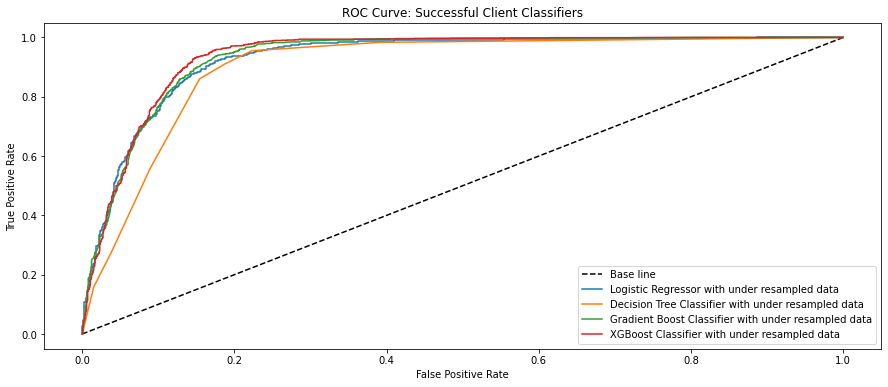

In [34]:
visualize_ROC_curves(y_under_test,y_under_test_pred_proba_df)

In [35]:
#visualize_RR_curves(y_under_test,y_under_test_pred_proba_df)
#Recall - Precision curve

### O P T I M A L    model

In [22]:
## init the optimal model
optimal_model = XGBClassifier(n_estimators=1000, learning_rate=0.003, use_label_encoder = False)
optimal_name = 'XGBClassifier on undersampled data'
X_opt_train = X_under_train
X_opt_test = X_under_test
y_opt_train = y_under_train
y_opt_test = y_under_test

optimal_model.fit(X_opt_train,y_opt_train)
y_opt_test_pred = optimal_model.predict(X_opt_test)

[22:19:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [23]:
## Hệ số mô hình tối ưu
features = [i for i in process_mkt_df.columns.values.tolist() if i!= target]
opt_model_coef = pd.Series(data = optimal_model.feature_importances_, index = features, name = optimal_name)
opt_model_coef.sort_values(ascending = False)
## The coefficients of the optimal model

nr.employed       0.407713
duration          0.137162
cons.conf.idx     0.136778
emp.var.rate      0.078797
euribor3m         0.040516
pdays             0.028271
month             0.025248
poutcome          0.022865
cons.price.idx    0.017795
default           0.017060
contact           0.013465
day_of_week       0.013029
education         0.011046
age               0.009168
previous          0.008548
campaign          0.007743
job               0.007310
loan              0.006467
marital           0.006097
housing           0.004921
Name: XGBClassifier on undersampled data, dtype: float32

In [24]:
## ghi vào file pickle
with open("model/pkl_model.pkl","wb") as f:
    pickle.dump(optimal_model,f)

### O P T I M A L    ROI

In [49]:
### Real R O I trên tập Undersampled Test: X_opt_test
## ROI = roi_per_success * # of sales - cost_per_call * # of calls

cost_per_call = 10
roi_per_success = 20

number_client = len(y_opt_test)
real_roi = get_real_roi(y_opt_test,cost_per_call,roi_per_success)
pred_roi = get_pred_roi(y_opt_test, y_opt_test_pred)

print('The gained ROI when predicting for {} clients'.format(number_client))
print('The real revenue: '+str(real_roi))
print('The predicted revenue: '+str(pred_roi))
print('The ROI: '+str(pred_roi - real_roi))

The gained ROI when predicting for 2784 clients
The real revenue: -40
The predicted revenue: 11130
The ROI: 11170


#### S T U F F   research

In [ ]:
### processing input data
def process_input_client(client_df):
    num_cols = marketing_df.dtypes[marketing_df.dtypes != 'object'].index.tolist()
    cat_cols = [col for col in marketing_df.dtypes[marketing_df.dtypes == 'object'].index.tolist() if col != 'y']

    missing_val = 'unknown'
    un_replaced_lst = ['default']
    for col in cat_cols:
        if (col in un_replaced_lst):
            continue
        replaced_val = marketing_df[col].mode().values.tolist()[0]
        client_df[col] = client_df[col].apply(lambda val: replaced_val if val == missing_val else val)


    for col in num_cols:
        if col == 'pdays':
            client_df[col] = client_df[col].map(transform_pdays)
            cat_cols = cat_cols +['pdays'] 
            continue

        if col == 'campaign':
            replaced_val = 6
        else:
            replaced_val = marketing_df[col].quantile(0.95)   

        client_df[col] = client_df[col].apply(lambda val: replaced_val if val > replaced_val else val)

    ## onehot_encoding:
    cat_cols = [col for col in client_df.dtypes[client_df.dtypes == 'object'].index.tolist()]  
    labelencoder = LabelEncoder()
    for column in cat_cols:
        client_df[column] = labelencoder.fit_transform(client_df[column])
    return(client_df)   

In [27]:
## load model from file
model = pickle.load(open("model/pkl_model.pkl", 'rb'))
scaler = pickle.load(open("model/pkl_scaler.pkl", 'rb'))

In [37]:
client_df = pd.read_csv('X_client_df.csv')
client_df.columns.tolist()
features = [col for col in marketing_df.columns.tolist() if col != 'y']
X_client = process_input_client(client_df[features])

,Unnamed: 0,age,job,marital,education,default,housing,loan,contact,month,...,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,0,56,housemaid,married,basic.4y,no,no,no,telephone,may,...,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,1,57,services,married,high.school,unknown,no,no,telephone,may,...,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,2,37,services,married,high.school,no,yes,no,telephone,may,...,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,3,40,admin.,married,basic.6y,no,no,no,telephone,may,...,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,4,56,services,married,high.school,no,no,yes,telephone,may,...,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


In [28]:
X_client = scaler.transform(X_client)
y_client_pred = model.predict(X_client)

In [29]:
pred_success_cnt = sum((y_client_pred == 1))
total_cnt = len(y_client_pred)
print (str(round(pred_success_cnt/total_cnt * 100,2))+"% clients will say YES")

54.0% clients will say YES


In [56]:
client_df['y'] = y_client_pred
display_features = [col for col in client_df.columns.tolist() if col not in features ]


In [57]:
def visualize_predicted_result(df, target):
    data = df.groupby(target).size().sort_values(ascending=False)
    label_dict = {1:'yes',0:'no'}
    fig = plt.figure(figsize = (6,4))
    plt.pie(x=data , autopct="%.1f%%", explode=[0.05]*len(data), labels= [label_dict[val] for val in data.index.tolist()]);
    plt.title("The predicted percentage of success");

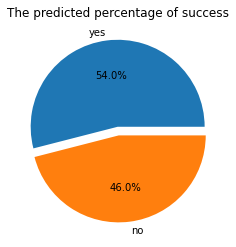

In [58]:
visualize_predicted_result(client_df,'y')
# data = client_df[display_features].groupby('y').size().sort_values(ascending=False)
# label_dict = {1:'yes',0:'no'}

# plt.pie(x=data , autopct="%.1f%%", explode=[0.05]*len(data), labels= [label_dict[val] for val in data.index.tolist()]);
# plt.title("The percentage of success");

In [38]:
#!pip install --user imbalanced-learn
# Thử over_sample
# import numpy as np
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

# ros = RandomOverSampler(random_state=123)
# X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
# re_eval_df,y_retest_pred_proba_df = run_model(names[1], models[1], X_train_resampled, y_train_resampled, X_test, y_test)
# print(re_eval_df)


In [47]:
# Thử under_sample
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=123)
# X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)
# un_eval_df,y_untest_pred_proba_df = run_model(names[1], models[1], X_train_undersampled, y_train_undersampled, X_test, y_test)
# print(un_eval_df)

In [ ]:
# # ghi vào file json
# import json
# features = [i for i in process_mkt_df.columns.values.tolist() if i!= target]
# model_coef_dict = {}

# for i in range(len(features)):
#     model_coef_dict[features[i]] = str(optimal_model.feature_importances_[i])

# with open('optimal_model.json', 'w') as outfile:
#     json.dump(model_coef_dict, outfile)

In [ ]:
# # ghi vào file pickle
# import pickle
# with open("optimal_model.pkl","wb") as f:
#     pickle.dump(optimal_model,f)
    
# # with open("optimal_model.pkl",'rb') as f:
# #             rf=pickle.load(f)

In [ ]:
# https://www.miai.vn/2021/01/18/k-fold-cross-validation-tuyet-chieu-train-khi-it-du-lieu/
